In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Ref: https://www.tensorflow.org/text/tutorials/text_classification_rnn

# Packages Imports

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 4.8 MB/s 
     |████████████████████████████████| 163 kB 44.5 MB/s 
     |████████████████████████████████| 212 kB 47.2 MB/s 
     |████████████████████████████████| 115 kB 48.0 MB/s 
     |████████████████████████████████| 127 kB 51.2 MB/s 
     |████████████████████████████████| 115 kB 54.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [3]:
import re
import os
import nltk
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stopword_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

print(f'Tensorflow Version: {tf.__version__}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Tensorflow Version: 2.9.2


# Dataset Preparation

In [4]:
banking_data = load_dataset('banking77')

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /root/.cache/huggingface/datasets/banking77/default/1.1.0/ff44c4421d7e70aa810b0fa79d36908a38b87aff8125d002cd44f7fcd31f493c. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
train_df = banking_data['train'].to_pandas()
test_df = banking_data['test'].to_pandas()

labels = ["activate_my_card", "age_limit", "apple_pay_or_google_pay", "atm_support", 
          "automatic_top_up", "balance_not_updated_after_bank_transfer", 
          "balance_not_updated_after_cheque_or_cash_deposit", 
          "beneficiary_not_allowed", "cancel_transfer", "card_about_to_expire", "card_acceptance", 
          "card_arrival", "card_delivery_estimate", "card_linking", "card_not_working", 
          "card_payment_fee_charged", "card_payment_not_recognised", "card_payment_wrong_exchange_rate", 
          "card_swallowed", "cash_withdrawal_charge", "cash_withdrawal_not_recognised", "change_pin", 
          "compromised_card", "contactless_not_working", "country_support", "declined_card_payment", 
          "declined_cash_withdrawal", "declined_transfer", "direct_debit_payment_not_recognised", 
          "disposable_card_limits", "edit_personal_details", "exchange_charge", "exchange_rate", 
          "exchange_via_app", "extra_charge_on_statement", "failed_transfer", "fiat_currency_support", 
          "get_disposable_virtual_card", "get_physical_card", "getting_spare_card", "getting_virtual_card", 
          "lost_or_stolen_card", "lost_or_stolen_phone", "order_physical_card", "passcode_forgotten", 
          "pending_card_payment", "pending_cash_withdrawal", "pending_top_up", "pending_transfer", 
          "pin_blocked", "receiving_money", "Refund_not_showing_up", "request_refund", "reverted_card_payment?", 
          "supported_cards_and_currencies", "terminate_account", "top_up_by_bank_transfer_charge", 
          "top_up_by_card_charge", "top_up_by_cash_or_cheque", "top_up_failed", "top_up_limits", 
          "top_up_reverted", "topping_up_by_card", "transaction_charged_twice", "transfer_fee_charged", 
          "transfer_into_account", "transfer_not_received_by_recipient", "transfer_timing", 
          "unable_to_verify_identity", "verify_my_identity", "verify_source_of_funds", "verify_top_up", 
          "virtual_card_not_working", "visa_or_mastercard", "why_verify_identity", "wrong_amount_of_cash_received", 
          "wrong_exchange_rate_for_cash_withdrawal"]
print(f'Train samples: {len(train_df)}\nTest Samples: {len(test_df)}')
print(f'Number of Intent labels: {len(labels)}')

Train samples: 10003
Test Samples: 3080
Number of Intent labels: 77


In [ ]:
# Find the length of content text

content_length = []

for i in train_df['text']:
  content_length.append(len(i))

In [ ]:
print(f'Content Length Stats')
print(f'Min: {min(content_length)}, Max: {max(content_length)}, Mean: {np.mean(content_length)}, Median: {np.median(content_length)}')

Content Length Stats
Min: 4, Max: 319, Mean: 38.66385247722728, Median: 31.0


In [6]:
def get_record(index:int, data:pd.DataFrame=train_df, label_mapping:list=labels) -> dict:
  record = data.iloc[index]
  return record['text'], label_mapping[record['label']]

In [ ]:
text, label = get_record(index=890)
print(f'{text}\n{label}')

I want to have multiple currencies in my account if possible.
fiat_currency_support


# Dataset Cleaning & Transformation

#### Step 1: Missing values

In [ ]:
train_df.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
test_df.isnull().sum()

text     0
label    0
dtype: int64

#### Step 2: Duplicate records

In [ ]:
duplicate_rows = len([index for index, item in enumerate(train_df['text'].duplicated()) if item])
print(f'Number of duplicate rows: {duplicate_rows}')

Number of duplicate rows: 0


In [ ]:
duplicate_rows = len([index for index, item in enumerate(test_df['text'].duplicated()) if item])
print(f'Number of duplicate rows: {duplicate_rows}')

Number of duplicate rows: 0


#### Step 3: Imbalance dataset

In [ ]:
train_df['label'].value_counts()

15    187
28    182
6     181
75    180
19    177
     ... 
41     82
18     61
10     59
72     41
23     35
Name: label, Length: 77, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


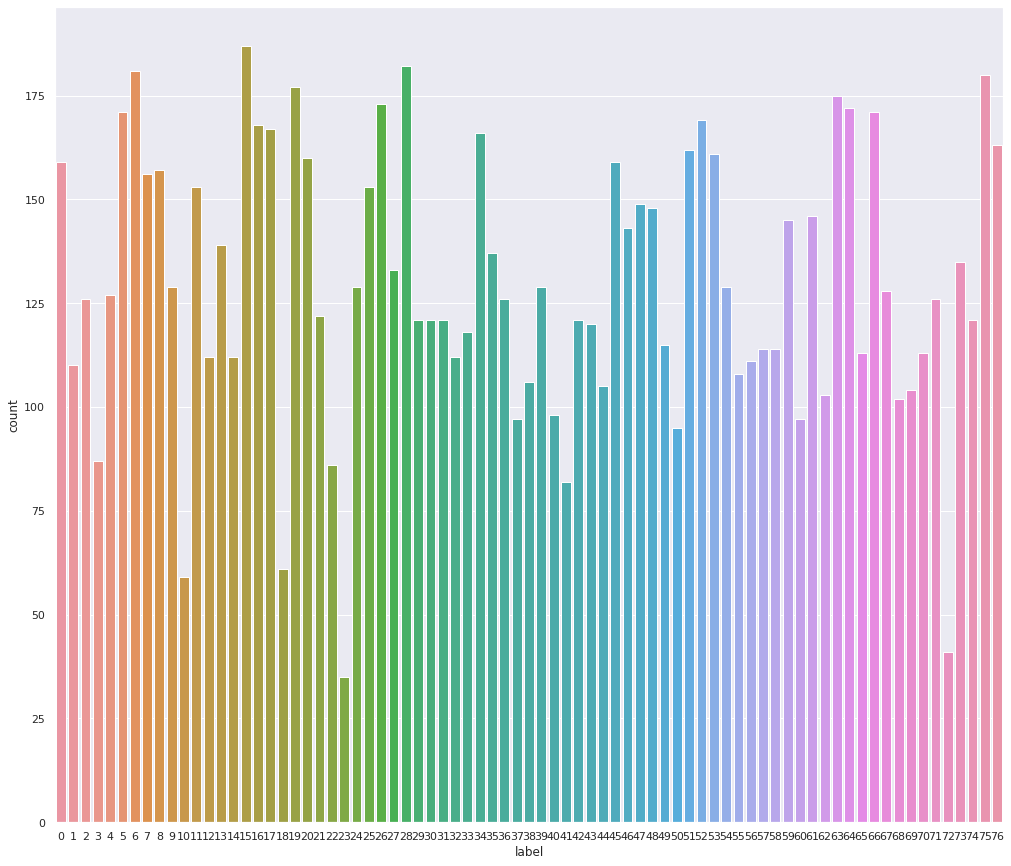

In [ ]:
sns.set(rc={'figure.figsize':(17,15)})
sns.countplot(train_df['label'])

#### Step 4: Text Preprocessing
##### - Remove stopwords
##### - Remove unicode characters
##### - Lower text
##### - Lemitization
##### - Label Encoding

In [7]:
def text_processing(text:str, stopword_set:set=stopword_set, lemmatizer=lemmatizer) -> str:

  # Create a space between word and the punctuation following it
  text = re.sub(r"([?.!,¿])", r" \1 ", text)
  text = re.sub(r'[" "]+', " ", text)
  # Remove Stopwords, Punctuations, and Lower the text
  non_stopwords = [word.lower() for word in nltk.word_tokenize(text) if word not in stopword_set and word not in string.punctuation]
  # Remove unicode characters
  non_unicode_words = ["".join([char for char in word if char.isalnum()]) for word in non_stopwords]
  # Lemitize the words
  lemmitised_words = [lemmatizer.lemmatize(word) for word in non_unicode_words]
  return " ".join(lemmitised_words)

In [ ]:
# Example
print(f'Original Text:\n{text}\nPreProcessed Text:\n{text_processing(text)}\nLabel: {label}')

Original Text:
I want to have multiple currencies in my account if possible.
PreProcessed Text:
i want multiple currency account possible
Label: fiat_currency_support


In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: text_processing(x))
test_df['text'] = test_df['text'].apply(lambda x: text_processing(x))

#### Step 5: Train Validation Split

In [8]:
def get_datasplit(data:pd.DataFrame, split_percent:float=0.1):
  train, test = train_test_split(data, test_size=split_percent, stratify=data['label'])
  return train, test

In [ ]:
train_df, valid_df = get_datasplit(train_df)

In [ ]:
train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [ ]:
def get_one_hot_targets(labels:pd.Series, num_classes:int):
  return tf.one_hot(labels, num_classes)

num_classes = 77
train_labels = get_one_hot_targets(train_df['label'], num_classes)
valid_labels = get_one_hot_targets(valid_df['label'], num_classes)
test_labels = get_one_hot_targets(test_df['label'], num_classes)

#### Step 6: TF Datasets

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df.text.values, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_df.text.values, test_labels))

In [ ]:
for example, label in train_ds.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'can someone assist updating account detail changing last name'
label:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


##### Sample Example

In [ ]:
print(f'Text: {example.numpy()}')
print(f'label: {np.argmax(label)}')
print(f'label class: {labels[np.argmax(label)]}')

Text: b'can someone assist updating account detail changing last name'
label: 30
label class: edit_personal_details


In [ ]:
# find vocabulary size:
vocab = set()
for text in train_df['text']:
  for word in text.split():
    vocab.add(word)
print(f'vocabular size: {len(vocab)}')

vocabular size: 2073


In [ ]:
BUFFER_SIZE = 10_000
BATCH_SIZE = 32
num_epochs = 70
num_classes = 77
VOCAB_SIZE = 2_000

#### Step 7: Shuffle, Batch & Repeat the datasets

In [ ]:
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat(num_epochs).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.repeat(num_epochs).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.repeat(num_epochs).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### Step 8: Text Encoding

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda text, label: text))

In [ ]:
n_words = 20
vocab = np.array(encoder.get_vocabulary())
print(f'First {n_words} vocabulary words:\n{vocab[:n_words]}')

First 20 vocabulary words:
['' '[UNK]' 'i' 'card' 'nt' 'account' 'transfer' 'how' 'money' 'what'
 'why' 'can' 'payment' 'get' 'need' 'cash' 'my' 'top' 'exchange' 'fee']


In [ ]:
# Encode a sequence into Text:

encoded_example = encoder(example).numpy()
print(f'Input sentence: {example}')
print(f'Input vector len: {len(encoded_example)}')
print(f'Input vector:\n{encoded_example}')
print(f'Input sentence label: {label}')
print(f'Input sentence label category: {labels[np.argmax(label)]}')
print(f'Input sentence label len: {len(label)}')

Input sentence: b'can someone assist updating account detail changing last name'
Input vector len: 9
Input vector:
[ 11  89 353 909   5 130 601 176 260]
Input sentence label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
Input sentence label category: edit_personal_details
Input sentence label len: 77


# LSTM Model

#### Definition

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
LSTM_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=100,
        name='EmbeddingLayer', mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu', name="FlattenLayer"),
    tf.keras.layers.Dense(77, name="OutputLayer", activation='softmax')
], name="LSTMModel")

In [ ]:
LSTM_model.summary()

Model: "LSTMModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 EmbeddingLayer (Embedding)  (None, None, 100)         200000    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 FlattenLayer (Dense)        (None, 16)                528       
                                                                 
 OutputLayer (Dense)         (None, 77)                1309      
                                                         

In [ ]:
LSTM_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

#### Model Training

In [ ]:
history = LSTM_model.fit(train_ds, epochs=num_epochs,
                        steps_per_epoch=len(train_ds) // BATCH_SIZE,
                        validation_data=valid_ds,
                        validation_steps=len(valid_ds)//BATCH_SIZE,  shuffle=True,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/70
615/615 [==============================] - 19s 23ms/step - loss: 4.3190 - accuracy: 0.0258 - val_loss: 4.2252 - val_accuracy: 0.0363
Epoch 2/70
615/615 [==============================] - 23s 38ms/step - loss: 4.0289 - accuracy: 0.0402 - val_loss: 3.8446 - val_accuracy: 0.0634
Epoch 3/70
615/615 [==============================] - 17s 28ms/step - loss: 3.7435 - accuracy: 0.0766 - val_loss: 3.6056 - val_accuracy: 0.1213
Epoch 4/70
615/615 [==============================] - 15s 25ms/step - loss: 3.5075 - accuracy: 0.1238 - val_loss: 3.3609 - val_accuracy: 0.1834
Epoch 5/70
615/615 [==============================] - 18s 29ms/step - loss: 3.2583 - accuracy: 0.1827 - val_loss: 3.1059 - val_accuracy: 0.2449
Epoch 6/70
615/615 [==============================] - 16s 26ms/step - loss: 2.9878 - accuracy: 0.2437 - val_loss: 2.8227 - val_accuracy: 0.3111
Epoch 7/70
615/615 [==============================] - 16s 25ms/step - loss: 2.7279 - accuracy: 0.3032 - val_loss: 2.5692 - val_accuracy:

615/615 [==============================] - 1s 2ms/step - loss: 0.7876 - accuracy: 0.7974 - val_loss: 1.0090 - val_accuracy: 0.7647


#### Performance Evaluation

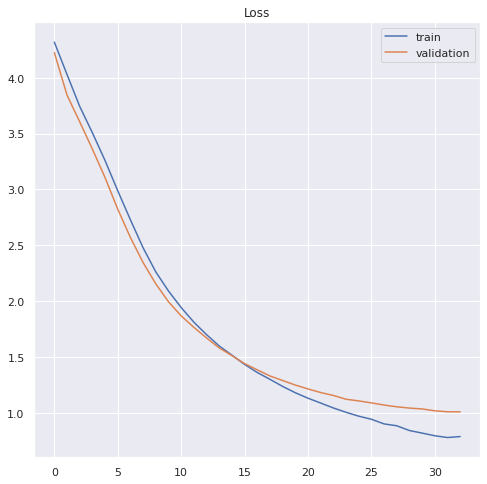

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.rcParams["figure.figsize"] = (5,5)
plt.legend()
plt.show();

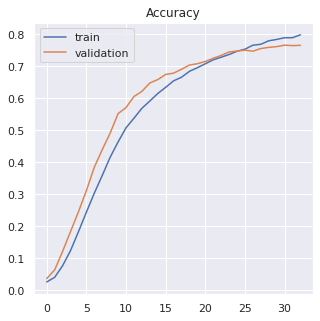

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.rcParams["figure.figsize"] = (5,5)
plt.legend()
plt.show();

In [ ]:
test_loss, test_acc = LSTM_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

6738/6738 [==============================] - 32s 5ms/step - loss: 1.0452 - accuracy: 0.7477
Test Loss: 1.0451632738113403
Test Accuracy: 0.7477272748947144


In [31]:
from sklearn.metrics import confusion_matrix, classification_report

In [30]:
def get_predictions_and_groundtruth(data, model, labels_values):
  y_pred = tf.argmax(model.predict(data), axis=1)
  y_true = tf.concat([np.argmax(y, axis=1) for x, y in test_ds], axis=0)
  assert len(y_pred) == len(y_true), "Number of data points are not same"

  y_pred_labels = [labels_values[i.numpy()] for i in y_pred]
  y_true_labels = [labels_values[i.numpy()] for i in y_true]

  return y_true_labels, y_pred_labels 

In [ ]:
y_true, y_pred = get_predictions_and_groundtruth(test_ds, LSTM_model, labels)

6738/6738 [==============================] - 32s 4ms/step


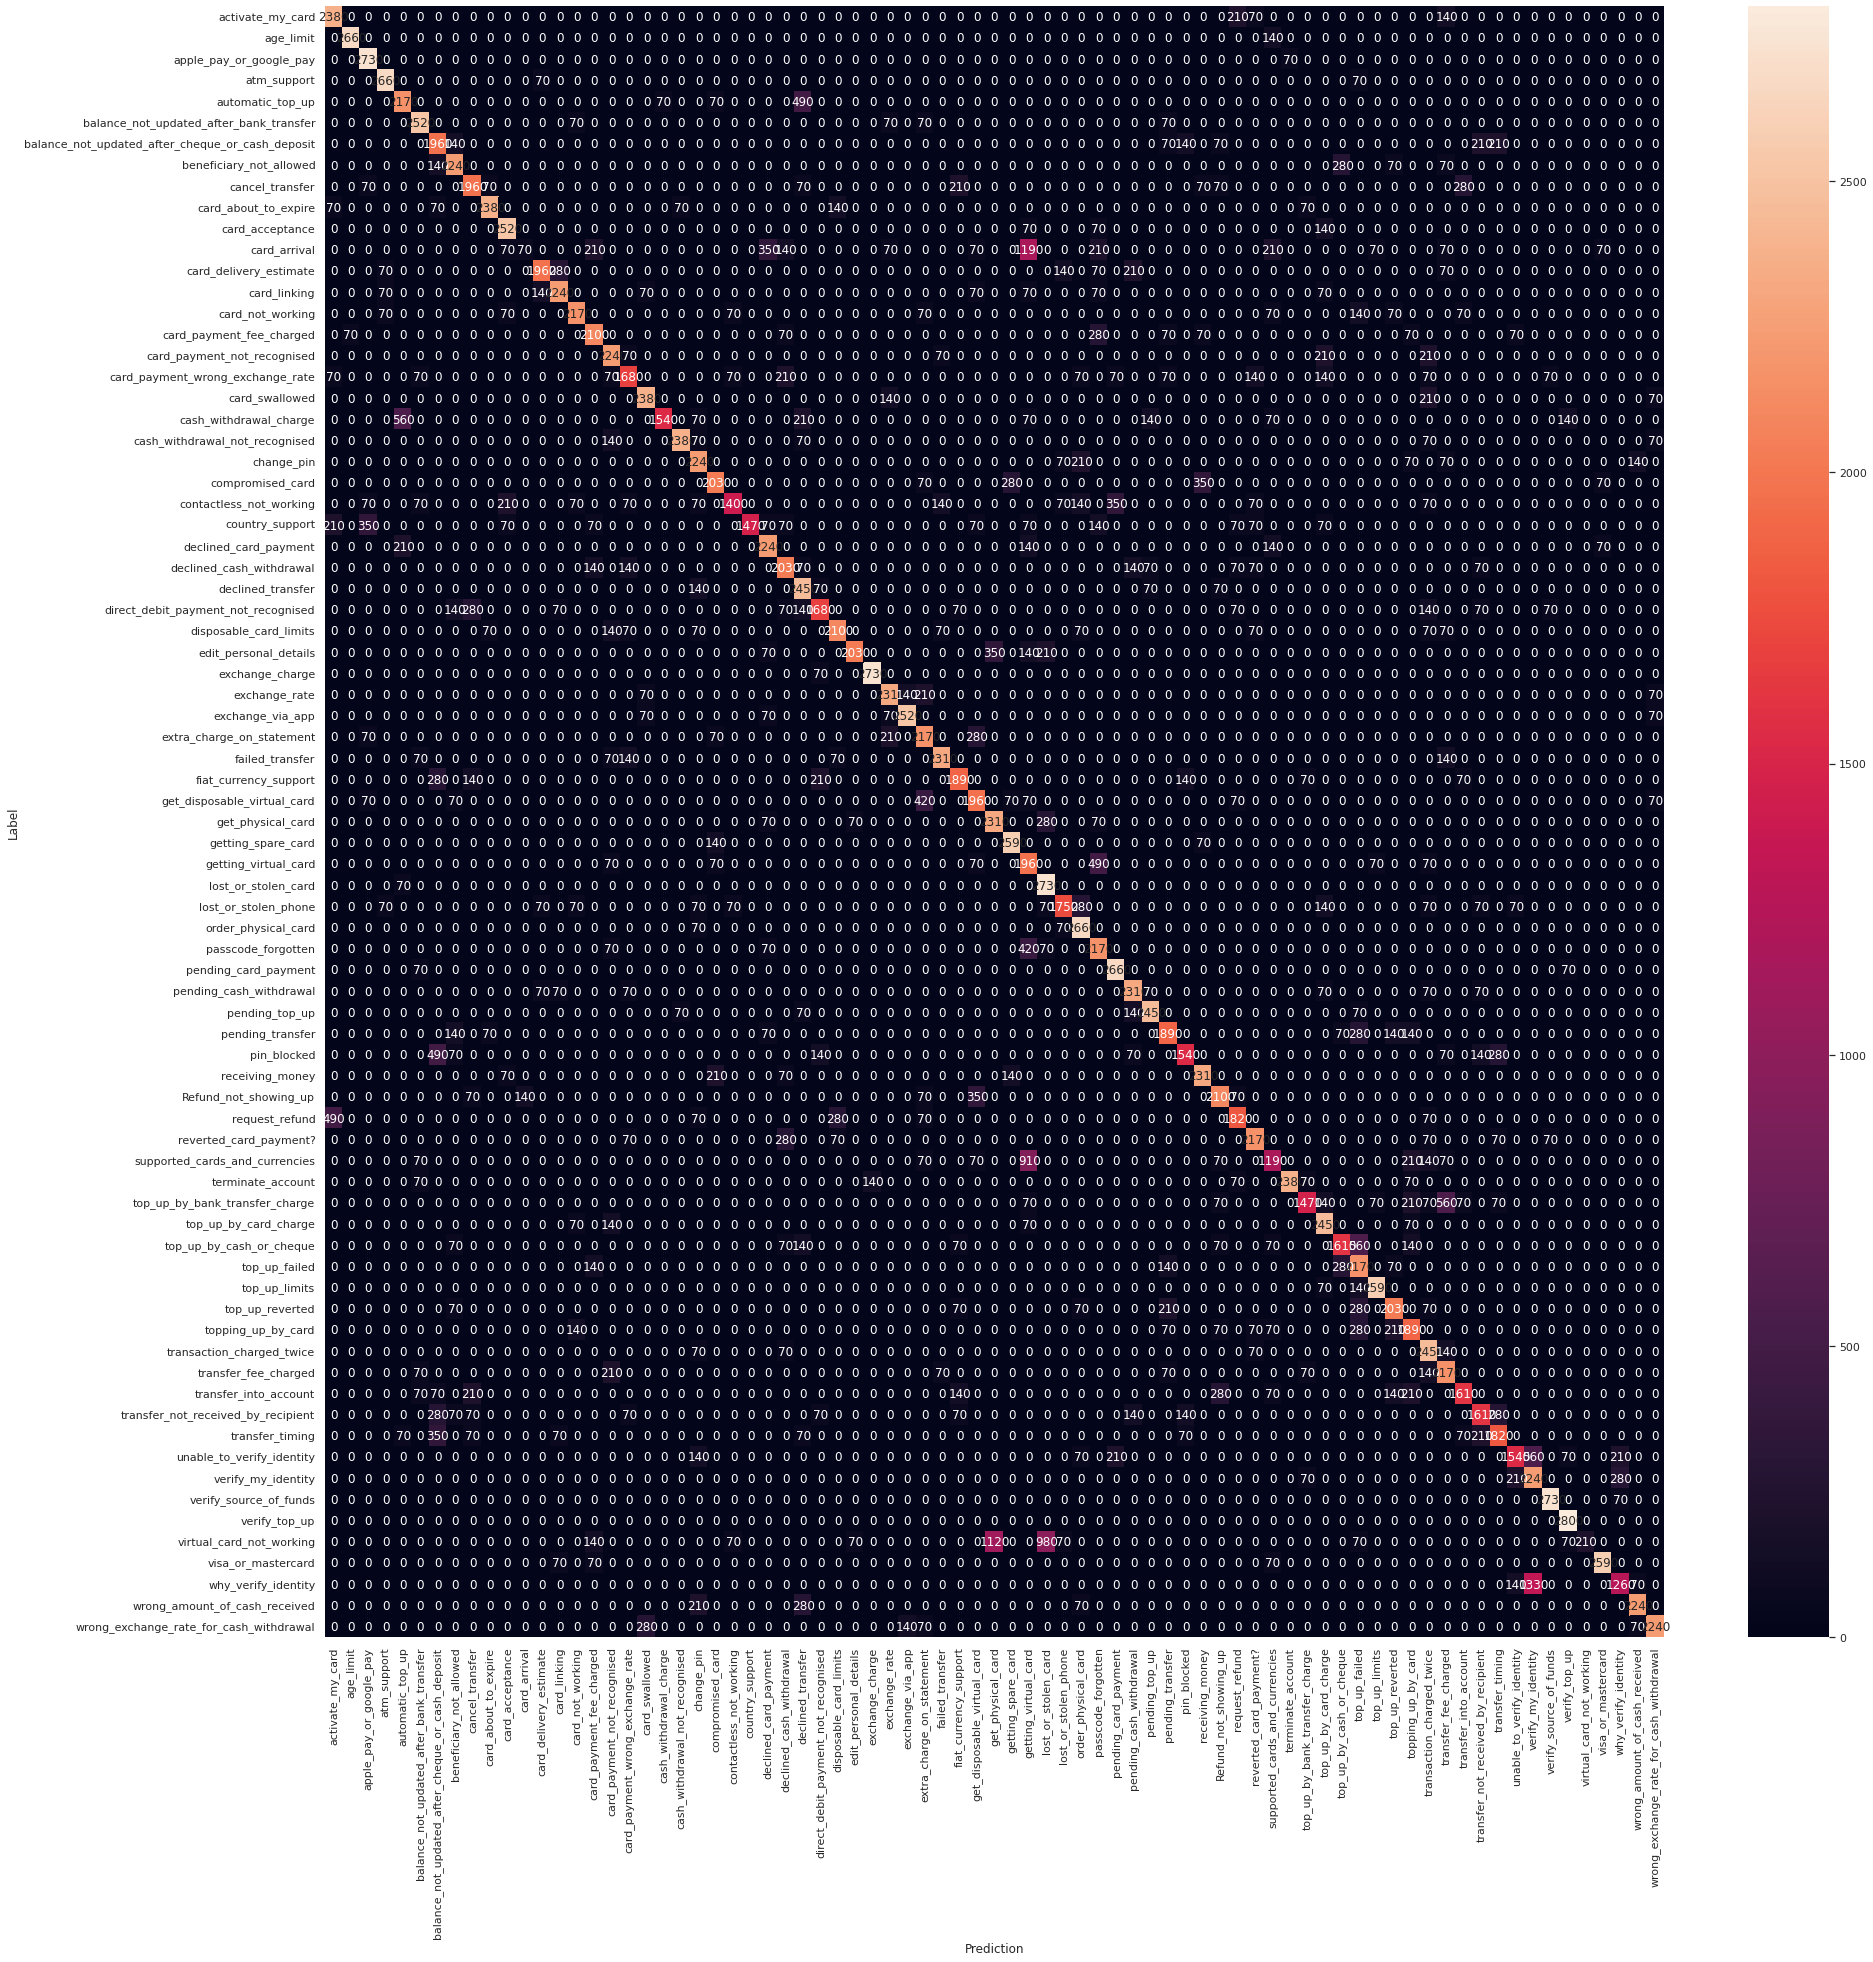

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.74      0.85      0.79      2800
                                activate_my_card       0.97      0.95      0.96      2800
                                       age_limit       0.81      0.97      0.89      2800
                         apple_pay_or_google_pay       0.90      0.95      0.93      2800
                                     atm_support       0.70      0.78      0.74      2800
                                automatic_top_up       0.82      0.90      0.86      2800
         balance_not_updated_after_bank_transfer       0.54      0.70      0.61      2800
balance_not_updated_after_cheque_or_cash_deposit       0.74      0.80      0.77      2800
                         beneficiary_not_allowed       0.70      0.70      0.70      2800
                                 cancel_transfer       0.92      0.85      0.88      2800
         

#### Inference:

In [39]:
def inference(text:str, model):
  text = text_processing(text)
  predictions = model.predict(np.array([text]))
  return labels[np.argmax(predictions)]

In [ ]:
text = 'Can you please replace the pin please'
# Expected label: "change_pin"
inference(text, LSTM_model)

1/1 [==============================] - 1s 1s/step


'change_pin'

In [ ]:
text = 'Hey, my card got stolen, can you please replace the pin please'
# Expected label: "change_pin"
inference(text, LSTM_model)

1/1 [==============================] - 0s 16ms/step


'card_about_to_expire'

In [ ]:
text = 'when will my card arrive?'
# Expected label: "card_arrival"
inference(text, LSTM_model)

1/1 [==============================] - 0s 17ms/step


'card_delivery_estimate'

In [ ]:
text = 'Hey, I applied for a new card, when will it reach me?'
inference(text, LSTM_model)

1/1 [==============================] - 0s 19ms/step


'lost_or_stolen_card'

In [ ]:
text = 'Hello team, on tuesday morning when I was walking past the market I`ve unfortunately lost my card. Due to which I`m not able to make any transcations. Thereby I would like to report a lost card with your team'
# Expected label: "lost_or_stolen_card"
inference(text, LSTM_model)

1/1 [==============================] - 0s 20ms/step


'compromised_card'

In [ ]:
text = 'Hello team, on tuesday morning when I was walking past the market I`ve unfortunately lost my card. Due to which I`m not able to make any transcations. Thereby I would like to report a lost card with your team'
'lost_or_stolen_card'
# Expected label: "change_pin"
inference(text, LSTM_model)

1/1 [==============================] - 0s 23ms/step


'compromised_card'

#Transformers Model

In [9]:
train_df = banking_data['train'].to_pandas()
test_df = banking_data['test'].to_pandas()

labels = ["activate_my_card", "age_limit", "apple_pay_or_google_pay", "atm_support", 
          "automatic_top_up", "balance_not_updated_after_bank_transfer", 
          "balance_not_updated_after_cheque_or_cash_deposit", 
          "beneficiary_not_allowed", "cancel_transfer", "card_about_to_expire", "card_acceptance", 
          "card_arrival", "card_delivery_estimate", "card_linking", "card_not_working", 
          "card_payment_fee_charged", "card_payment_not_recognised", "card_payment_wrong_exchange_rate", 
          "card_swallowed", "cash_withdrawal_charge", "cash_withdrawal_not_recognised", "change_pin", 
          "compromised_card", "contactless_not_working", "country_support", "declined_card_payment", 
          "declined_cash_withdrawal", "declined_transfer", "direct_debit_payment_not_recognised", 
          "disposable_card_limits", "edit_personal_details", "exchange_charge", "exchange_rate", 
          "exchange_via_app", "extra_charge_on_statement", "failed_transfer", "fiat_currency_support", 
          "get_disposable_virtual_card", "get_physical_card", "getting_spare_card", "getting_virtual_card", 
          "lost_or_stolen_card", "lost_or_stolen_phone", "order_physical_card", "passcode_forgotten", 
          "pending_card_payment", "pending_cash_withdrawal", "pending_top_up", "pending_transfer", 
          "pin_blocked", "receiving_money", "Refund_not_showing_up", "request_refund", "reverted_card_payment?", 
          "supported_cards_and_currencies", "terminate_account", "top_up_by_bank_transfer_charge", 
          "top_up_by_card_charge", "top_up_by_cash_or_cheque", "top_up_failed", "top_up_limits", 
          "top_up_reverted", "topping_up_by_card", "transaction_charged_twice", "transfer_fee_charged", 
          "transfer_into_account", "transfer_not_received_by_recipient", "transfer_timing", 
          "unable_to_verify_identity", "verify_my_identity", "verify_source_of_funds", "verify_top_up", 
          "virtual_card_not_working", "visa_or_mastercard", "why_verify_identity", "wrong_amount_of_cash_received", 
          "wrong_exchange_rate_for_cash_withdrawal"]
print(f'Train samples: {len(train_df)}\nTest Samples: {len(test_df)}')
print(f'Number of Intent labels: {len(labels)}')

train_df, valid_df = get_datasplit(train_df)

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# find vocabulary size:
vocab = set()
for text in train_df['text']:
  for word in text.split():
    vocab.add(word)
print(f'We have {len(vocab)} unique words')

def get_one_hot_targets(labels:pd.Series, num_classes:int):
  return tf.one_hot(labels, num_classes)

num_classes = 77
train_labels = get_one_hot_targets(train_df['label'], num_classes)
valid_labels = get_one_hot_targets(valid_df['label'], num_classes)
test_labels = get_one_hot_targets(test_df['label'], num_classes)

train_ds = tf.data.Dataset.from_tensor_slices((train_df.text.values, train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_df.text.values, test_labels))

Train samples: 10003
Test Samples: 3080
Number of Intent labels: 77
We have 4273 unique words


In [10]:
BUFFER_SIZE = 10_000
BATCH_SIZE = 32
num_epochs = 70
num_classes = 77
VOCAB_SIZE = 2_000
MAX_LEN = 35

In [11]:
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat(num_epochs).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.repeat(num_epochs).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.repeat(num_epochs).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
transformers_text_encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
                                                         output_sequence_length=MAX_LEN)
transformers_text_encoder.adapt(train_ds.map(lambda text, label: text))

In [13]:
n_words = 20
vocab = np.array(transformers_text_encoder.get_vocabulary())
print(f'First {n_words} vocabulary words:\n{vocab[:n_words]}')

First 20 vocabulary words:
['' '[UNK]' 'i' 'my' 'to' 'a' 'the' 'card' 'is' 'do' 'it' 'can' 'for'
 'how' 'what' 'why' 'account' 'you' 'and' 'money']


In [14]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        # Represent position of token using this range
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [15]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), 
             tf.keras.layers.Dense(embed_dim)]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [16]:
tf.keras.backend.clear_session()

In [46]:
embed_dim = 50  # Embedding size for each token
num_heads = 3 # Number of Attention Heads
ff_dim = 32  # Number of MLP units inside Transformer Encoder

In [47]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = transformers_text_encoder(inputs)
embedding_layer = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, embed_dim)
x = embedding_layer(x)
transformer_encoder_block = TransformerEncoder(embed_dim, num_heads, ff_dim)
x = transformer_encoder_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

transformers_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [48]:
transformers_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 35)               0         
 torization)                                                     
                                                                 
 token_and_position_embeddin  (None, 35, 50)           101750    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_encoder_1 (Tran  (None, 35, 50)           33982     
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d_1   (None, 50)               0   

In [49]:
transformers_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(1e-4),
                           metrics=['accuracy'])

In [50]:
history = transformers_model.fit(train_ds, epochs=num_epochs,
                                 steps_per_epoch=len(train_ds) // BATCH_SIZE,
                                 validation_data=valid_ds,
                                 validation_steps=len(valid_ds)//BATCH_SIZE,  shuffle=True,
                                 callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/70
615/615 [==============================] - 38s 58ms/step - loss: 4.3262 - accuracy: 0.0196 - val_loss: 4.2720 - val_accuracy: 0.0230
Epoch 2/70
615/615 [==============================] - 21s 34ms/step - loss: 4.1407 - accuracy: 0.0415 - val_loss: 3.8933 - val_accuracy: 0.0676
Epoch 3/70
615/615 [==============================] - 21s 35ms/step - loss: 3.5408 - accuracy: 0.1126 - val_loss: 3.0750 - val_accuracy: 0.2091
Epoch 4/70
615/615 [==============================] - 21s 35ms/step - loss: 2.7353 - accuracy: 0.2969 - val_loss: 2.2379 - val_accuracy: 0.4752
Epoch 5/70
615/615 [==============================] - 21s 34ms/step - loss: 2.0830 - accuracy: 0.4758 - val_loss: 1.7042 - val_accuracy: 0.6374
Epoch 6/70
615/615 [==============================] - 23s 38ms/step - loss: 1.6699 - accuracy: 0.5815 - val_loss: 1.3726 - val_accuracy: 0.6884
Epoch 7/70
615/615 [==============================] - 22s 37ms/step - loss: 1.3813 - accuracy: 0.6535 - val_loss: 1.1767 - val_accuracy:

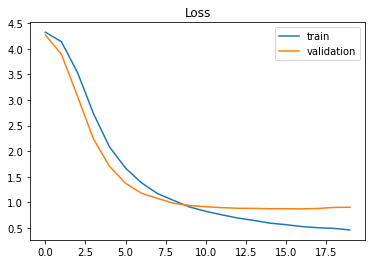

In [52]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

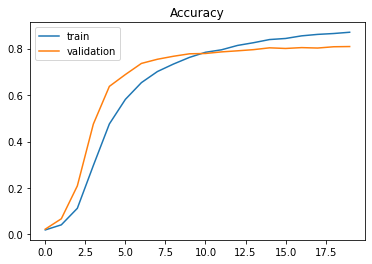

In [53]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

In [54]:
test_loss, test_acc = transformers_model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

6738/6738 [==============================] - 87s 13ms/step - loss: 0.9082 - accuracy: 0.8058
Test Loss: 0.9081723093986511
Test Accuracy: 0.8058441281318665


In [55]:
y_true, y_pred = get_predictions_and_groundtruth(test_ds, transformers_model, labels)

6738/6738 [==============================] - 92s 14ms/step


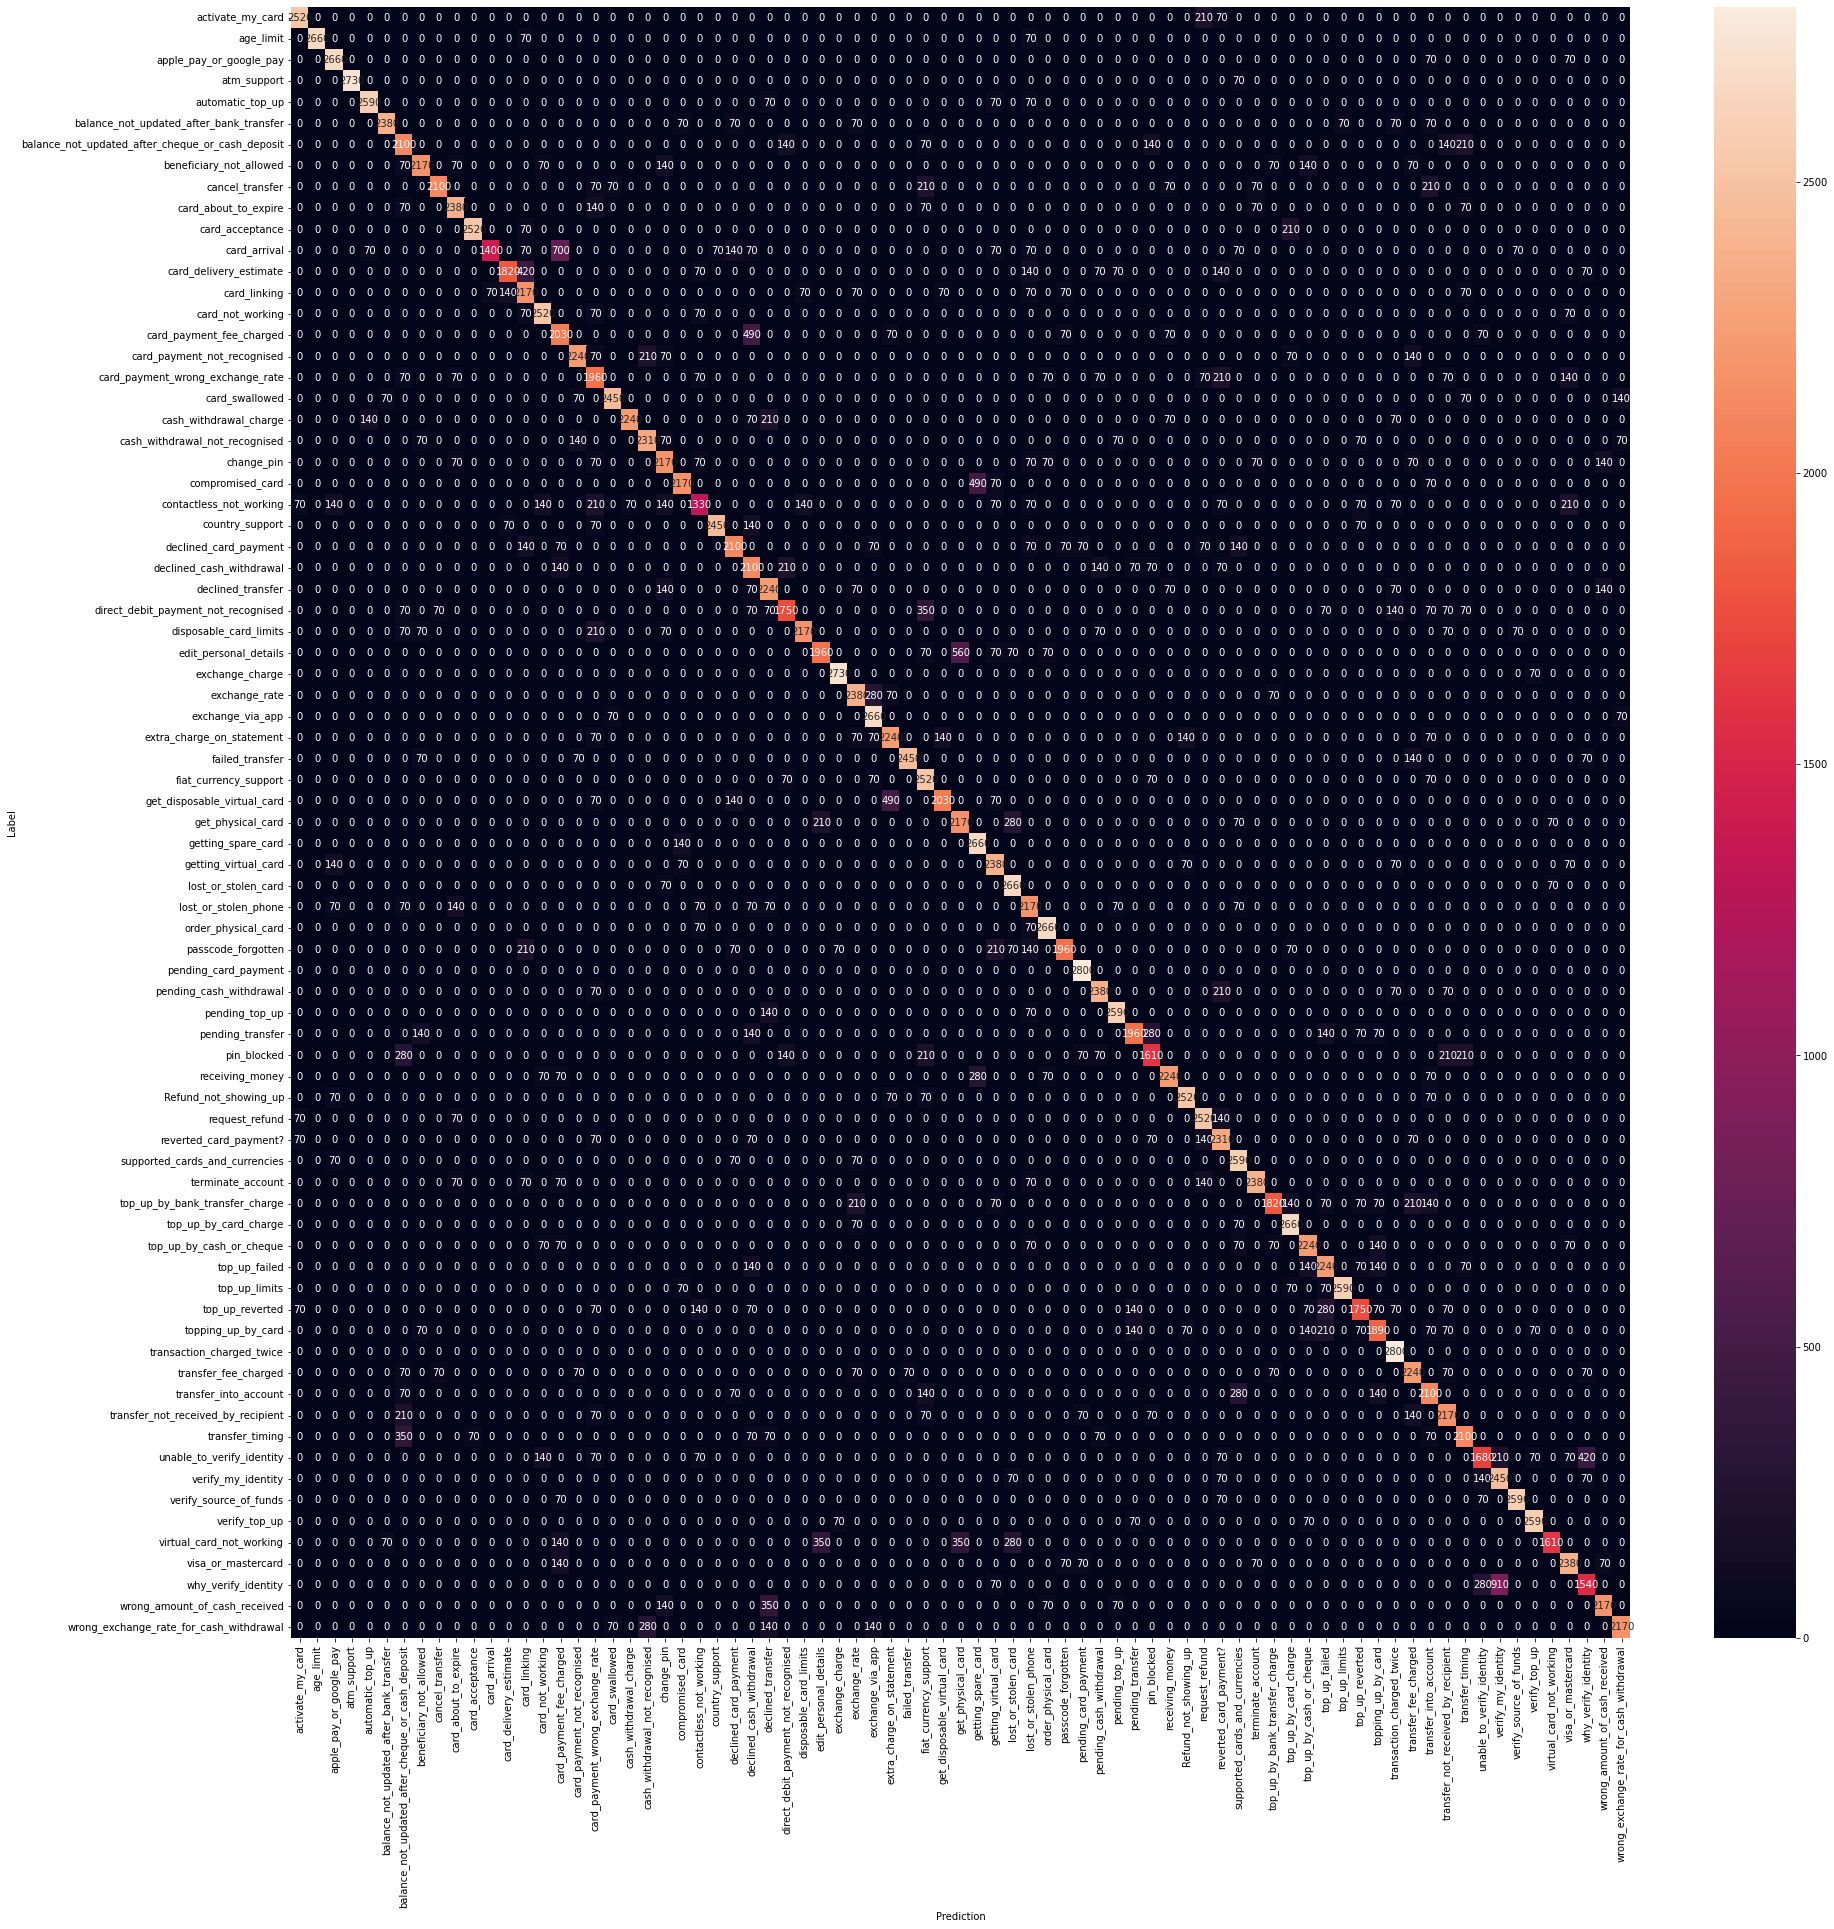

In [56]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [57]:
print(classification_report(y_true, y_pred))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.90      0.90      0.90      2800
                                activate_my_card       1.00      0.95      0.97      2800
                                       age_limit       0.84      0.95      0.89      2800
                         apple_pay_or_google_pay       1.00      0.97      0.99      2800
                                     atm_support       0.93      0.93      0.93      2800
                                automatic_top_up       0.94      0.85      0.89      2800
         balance_not_updated_after_bank_transfer       0.60      0.75      0.67      2800
balance_not_updated_after_cheque_or_cash_deposit       0.84      0.78      0.81      2800
                         beneficiary_not_allowed       0.94      0.75      0.83      2800
                                 cancel_transfer       0.83      0.85      0.84      2800
         

In [58]:
text = 'Can you please replace the pin please'
# Expected label: "change_pin"
inference(text, transformers_model)

1/1 [==============================] - 0s 283ms/step


'change_pin'

In [59]:
text = 'Hey, my card got stolen, can you please replace the pin please'
# Expected label: "change_pin"
inference(text, transformers_model)

1/1 [==============================] - 0s 22ms/step


'change_pin'

In [60]:
text = 'when will my card arrive?'
# Expected label: "card_arrival"
inference(text, transformers_model)

1/1 [==============================] - 0s 26ms/step


'card_delivery_estimate'

In [61]:
text = 'Hey, I applied for a new card, when will it reach me?'
inference(text, transformers_model)

1/1 [==============================] - 0s 21ms/step


'transfer_timing'

In [62]:
text = 'Hello team, on tuesday morning when I was walking past the market I`ve unfortunately lost my card. Due to which I`m not able to make any transcations. Thereby I would like to report a lost card with your team'
# Expected label: "lost_or_stolen_card"
inference(text, transformers_model)

1/1 [==============================] - 0s 21ms/step


'reverted_card_payment?'

In [63]:
text = 'Hello team, on tuesday morning when I was walking past the market I`ve unfortunately lost my card. Due to which I`m not able to make any transcations. Thereby I would like to report a lost card with your team'
'lost_or_stolen_card'
# Expected label: "change_pin"
inference(text, transformers_model)

1/1 [==============================] - 0s 21ms/step


'reverted_card_payment?'

In [ ]:
# transformers_model.save('/content/gdrive/MyDrive/DBpedia-14-Text-Classification/transformer_model', save_format='tf')